# Lab - Dogs vs Cats

Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.

I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

## Uppgifter
Dokumentera i markdown i Jupyter notebook eller i separat markdownfil om du använder Pythonskript.

### 0. EDA och filhantering (*)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
!pip3 install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 KB 312.1 kB/s eta 0:00:0000:0100:01


#### c) Skapa folderstrukturen med Python

I manually removed the extra train and test folder, since these just created an unnecessary long file path. 

In [ ]:
#for size in ["small", "tiny"]:
#    os.mkdir(f"experiment_{size}_data")
#    for dataset in ["test", "train", "val"]:
#        os.mkdir(f"experiment_{size}_data/{dataset}")

#os.rename("Pictures_of_dogs_and_cats", "original_data")

#### a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [ ]:
def plot_random_sample(number_of_samples:int) -> None:
    """
    Plots a random sample of images from the original Dogs vs Cats data.
    Plots five pictures per row.
    
    Parameters
    ----------
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows are filled.
        
    Returns
    -------
    None
    """

    # Initialise variables
    labels = [random.choice(["cat", "dog"]) for i in range(number_of_samples)]
    numbers = random.sample(range(12500), number_of_samples)
    images = []

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)

    # Read the images and save the labels
    for label, number in zip(labels, numbers):
        images.append(plt.imread(f"original_data/train/{label}.{number}.jpg"))
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    for i, ax, label in zip(range(number_of_samples), axes.flatten(), labels):
        ax.imshow(images[i]) 
        ax.axis("off")
        if label == "cat":
            ax.set(title="Cat: 0")
        else:
            ax.set(title="Dog: 1")

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

In [ ]:
#plot_random_sample(10)

#### d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.

Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)

In [ ]:
# Saves all file names in the original data in a dataframe
#img_names = pd.DataFrame({"file_name" : os.listdir("original_data/train")})

# Creates cat column with True if the file name contains cat and False if the file name contains dog
#img_names["cat"] = img_names["file_name"].str.contains("cat") 

#cats = img_names[img_names["cat"] == True]
#dogs = img_names[img_names["cat"] == False]
#len(cats), len(dogs)

In [ ]:
def train_val_test_split(data1:pd.Series, data2:pd.Series, train_size:int, val_size:int, test_size:int) -> tuple:
    """
    Takes equally sized, random samples from two datasets,
    and splits them into training, validation and test data. 
    
    Parameters
    ----------
    data1 : pd.Series
        The file names in dataset 1
    data2 : pd.Series
        The file names in dataset 2
    train_size : int
        Size of training data 
    val_size : int
        Size of validation data 
    test_size : int
        Size of test data 
    
    Returns
    -------
    train, val, test : tuple[list, list, list]:
        A tuple of training, validation and test data 
    """

    # Half size for each dataset
    train_size = int(train_size/2)
    val_size = int(val_size/2)
    test_size = int(test_size/2)

    # Picks out a full sample 
    full_sample_size = train_size + val_size + test_size
    data1_full_sample = random.sample(list(data1), full_sample_size)
    data2_full_sample = random.sample(list(data2), full_sample_size)

    # Creates random training sample from the full sample and merge dataset 1 and 2
    data1_train = random.sample(data1_full_sample, train_size)
    data2_train = random.sample(data2_full_sample, train_size)
    train = data1_train + data2_train

    # Creates random validation sample from the data not used for training  and merge dataset 1 and 2
    data1_val = random.sample(list(set(data1_full_sample) - set(data1_train)), val_size) #Reference: https://stackoverflow.com/questions/41125909/python-find-elements-in-one-list-that-are-not-in-the-other
    data2_val = random.sample(list(set(data2_full_sample) - set(data2_train)), val_size)
    val = data1_val + data2_val

    # Creates random test sample from the data not used for training or validation and merge dataset 1 and 2
    data1_test = random.sample(list(set(data1_full_sample) - set(data1_train) - set(data1_val)), test_size)
    data2_test = random.sample(list(set(data2_full_sample) - set(data2_train) - set(data2_val)), test_size)
    test = data1_test + data2_test

    return train, val, test

In [ ]:
#train_small, val_small, test_small = train_val_test_split(cats["file_name"], dogs["file_name"], 1600, 400, 500)
#train_tiny, val_tiny, test_tiny = train_val_test_split(cats["file_name"], dogs["file_name"], 160, 40, 50)

In [ ]:
#print(f"{len(set(train_small))} out of a total of {len(train_small)} training samples are unique.")
#print(f"{len(set(val_small))} out of a total of {len(val_small)} validation samples are unique.")
#print(f"{len(set(test_small))} out of a total of {len(test_small)} test samples are unique.")

#print(f"Any image both in validation and training data? {any(sample in val_small for sample in train_small)}")
#print(f"Any image both in test and training data? {any(sample in test_small for sample in train_small)}")
#print(f"Any image both in validation and test data? {any(sample in val_small for sample in test_small)}")

In [ ]:
#for data, folder in zip([train_tiny, val_tiny, test_tiny], ["train", "val", "test"]):
    
#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_tiny_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

In [ ]:
#for data, folder in zip([train_small, val_small, test_small], ["train", "val", "test"]):

#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_small_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

### e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

plotta några bilder med deras respektive labels och kontrollera att det är korrekt.

In [ ]:
def read_images(folder_path:str) -> tuple:
    """
    Reads all images in the specified folder and extracts the label. 
    
    Parameters
    ----------
    folder_path : str
        The folder path from which to read the images.
    
    Returns
    -------
    data, labels : tuple[np.ndarray, np.ndarray]:
        A tuple of X and y data. 
    """

    data = []
    labels = []
    img_names = os.listdir(folder_path)

    # Reads the images
    for file in img_names:
        data.append(plt.imread(f"{folder_path}/{file}"))
    data = np.asarray(data, dtype=object)

    # Extract labels
    for img_name in img_names:
        if "cat" in img_name:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels)

    # Shuffle the data
    np.random.seed(42)
    np.random.shuffle(data)
    np.random.seed(42)
    np.random.shuffle(labels)

    return data, labels

In [ ]:
#X_train_small, y_train_small = read_images("experiment_small_data/train")
#X_val_small, y_val_small  = read_images("experiment_small_data/val")
#X_test_small, y_test_small = read_images("experiment_small_data/test")

#X_train_tiny, y_train_tiny = read_images("experiment_tiny_data/train")
#X_val_tiny, y_val_tiny = read_images("experiment_tiny_data/val")
#X_test_tiny, y_test_tiny = read_images("experiment_tiny_data/test")

In [ ]:
#os.mkdir("pickled_files")

In [ ]:
def pickle_file(dataset, filename):
    with open(f"pickled_files/{filename}.pickle", "wb") as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#pickle_file(X_train_small, "X_train_small")
#pickle_file(X_val_small, "X_val_small")
#pickle_file(X_test_small, "X_test_small")
#pickle_file(X_train_tiny, "X_train_tiny")
#pickle_file(X_val_tiny, "X_val_tiny")
#pickle_file(X_test_tiny, "X_test_tiny")

#pickle_file(y_train_small, "y_train_small")
#pickle_file(y_val_small, "y_val_small")
#pickle_file(y_test_small, "y_test_small")
#pickle_file(y_train_tiny, "y_train_tiny")
#pickle_file(y_val_tiny, "y_val_tiny")
#pickle_file(y_test_tiny, "y_test_tiny")

In [2]:
def open_pickle_file(dataset):
    with open(f'../input/dogsvscats/{dataset}.pickle', 'rb') as f:
        data = pickle.load(f)
        return data

In [3]:
X_train_small = open_pickle_file("X_train_small")
X_val_small = open_pickle_file("X_val_small")
X_test_small = open_pickle_file("X_test_small")
X_train_tiny = open_pickle_file("X_train_tiny")
X_val_tiny = open_pickle_file("X_val_tiny")
X_test_tiny = open_pickle_file("X_test_tiny")

y_train_small = open_pickle_file("y_train_small")
y_val_small = open_pickle_file("y_val_small")
y_test_small = open_pickle_file("y_test_small")
y_train_tiny = open_pickle_file("y_train_tiny")
y_val_tiny = open_pickle_file("y_val_tiny")
y_test_tiny = open_pickle_file("y_test_tiny")

In [4]:
print(X_train_small.shape, X_val_small.shape, X_test_small.shape, X_train_tiny.shape, X_val_tiny.shape, X_test_tiny.shape)
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

print(X_train_small[0].shape)

(1600,) (400,) (500,) (160,) (40,) (50,)
(1600,) (400,) (500,) (160,) (40,) (50,)
(499, 362, 3)


In [6]:
def plot_images(X, y, number_of_samples:int, start_index:int=0, random_sample:bool=False) -> None:
    """
    Plots five images per row. 
    
    Parameters
    ----------
    X : np.ndarray
        An array of images
    y : np.ndarray
        An array of labels
    number_of_samples : int
        The number of images to be plotted.
        Preferably the chosen number should be evenly divided by 5,
        so that all rows are filled.
    start : int
        The index of the image to start with (default 0)
    random_sample : bool
        If True, plots a random sample (default False)
        
    Returns
    -------
    None
    """

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples//5)+1)
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    if random_sample == True:
        sample = random.sample(range(len(X_train_small)), number_of_samples)
        for i, ax in zip(sample, axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])        
    else:
        for i, ax in zip(range(start_index, (start_index+number_of_samples)), axes.flatten()):
            ax.imshow(X[i]) 
            ax.axis("off")
            ax.set(title=y[i])

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

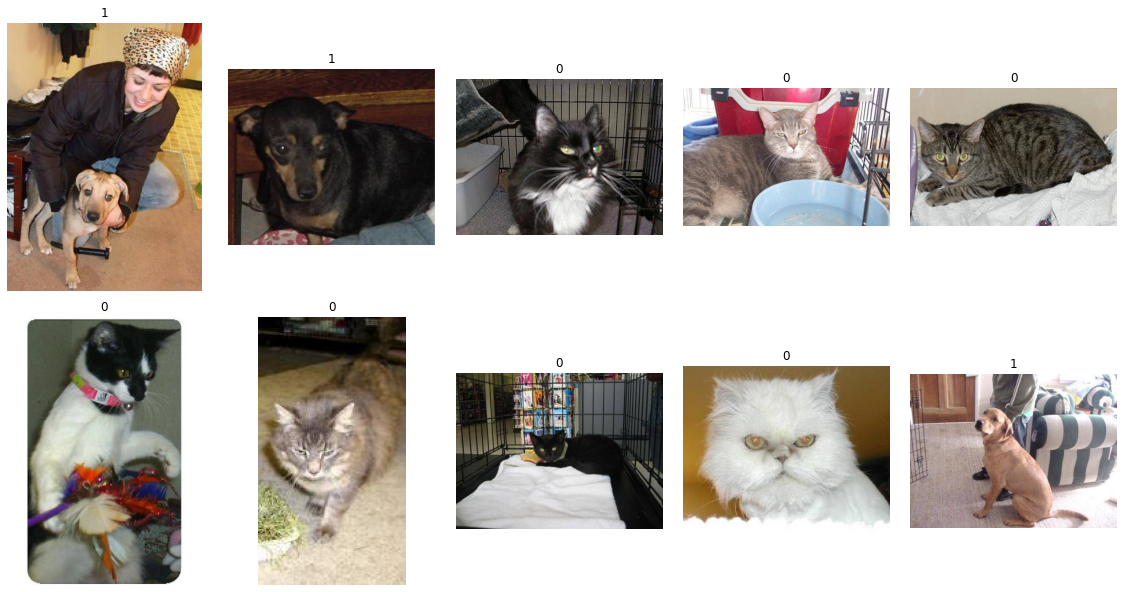

In [11]:
plot_images(X_train_small, y_train_small, 10)

skapa lämplig plot för att kontrollera att dataseten är balanserade

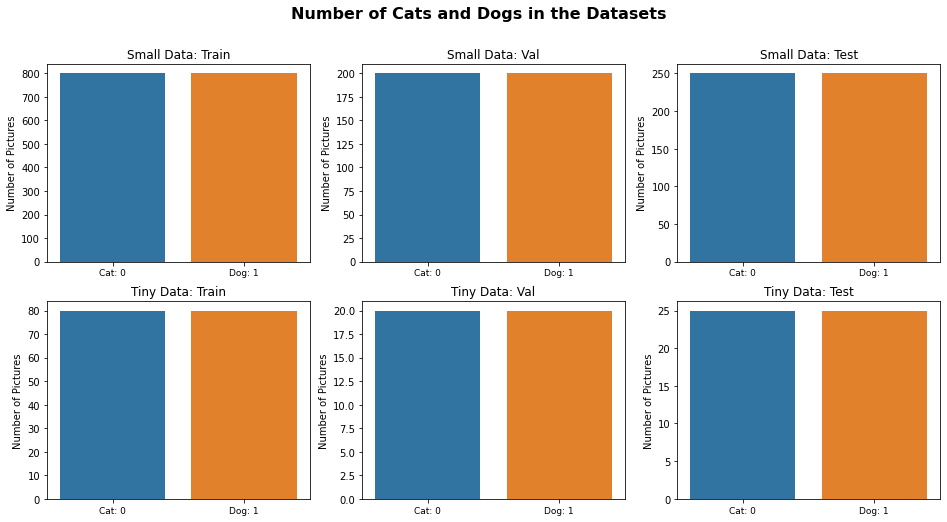

In [14]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Data: Train", "Small Data: Val", "Small Data: Test", "Tiny Data: Train", "Tiny Data: Val", "Tiny Data: Test"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of Pictures")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=9)

fig.suptitle("Number of Cats and Dogs in the Datasets", size=16, fontweight="bold");

skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

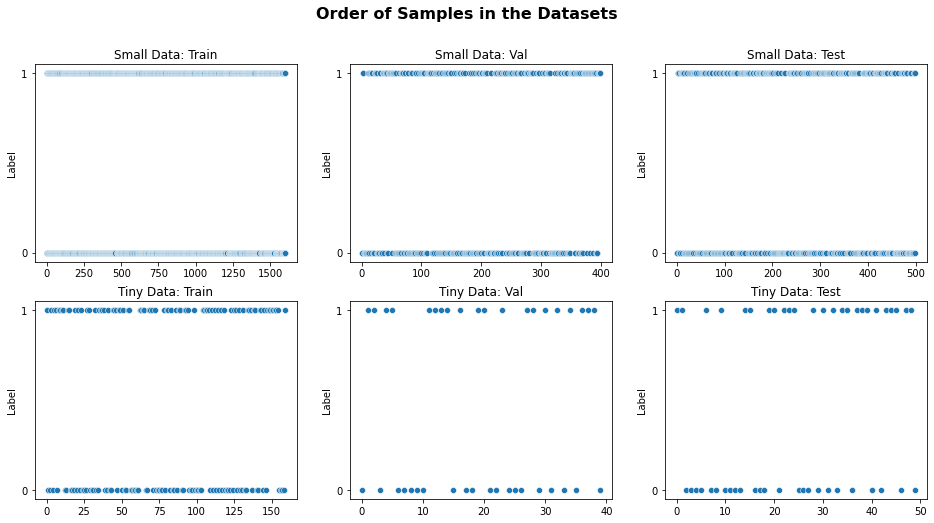

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Label")
    ax.locator_params(axis='y', nbins=2)
    ax.set_yticks([0, 1])

fig.suptitle("Order of Samples in the Datasets", size=16, fontweight="bold");

## 1. Bildbehandling (*)

Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

### a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [16]:
# Saves height and width (number of pixels) for small and tiny data
height_small = [X_train_small[i].shape[0] for i in range(len(X_train_small))]
width_small = [X_train_small[i].shape[1] for i in range(len(X_train_small))]

height_tiny = [X_train_tiny[i].shape[0] for i in range(len(X_train_tiny))]
width_tiny = [X_train_tiny[i].shape[1] for i in range(len(X_train_tiny))]

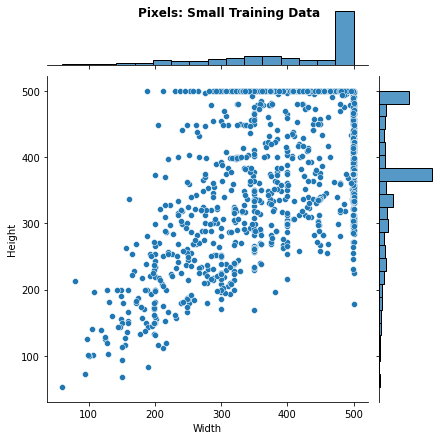

In [17]:
fig = sns.jointplot(x=width_small, y=height_small)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Small Training Data", size=12, fontweight="bold");

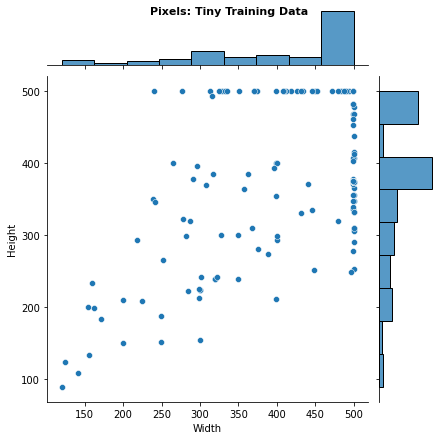

In [19]:
fig = sns.jointplot(x=width_tiny, y=height_tiny)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Tiny Training Data", size=11, fontweight="bold");

### b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

In [20]:
count = 0
for height, width in zip(height_small, width_small):
    if height < 150 or width < 150: 
        count += 1
print(f"{count} out of a {len(height_small)} images had a width or a height smaller than 150.")

43 out of a 1600 images had a width or a height smaller than 150.


Based on the plots above we can see that the smallest image has a size of 50 x 50 and that the largest image has a size of about 500 x 500. It is also common for the images to have a width OR a height of 500 and the other side between 200 and 500.

Downscaling is necessary to be able to run the analysis (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/). Based on earlier work (book reference) I choose an image size of 150 x 150, which provided an accuracy of ... In the small training data there are 43 images with a width or a height smaller than 150 and there are therefore substantially more images that will be downscaled than upscaled. I will therefore continue with all images. 

Below I will also try the model out with image sizes of 100 x 100 and 200 x 200. 

### c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande struktur:

(samples, row, cols, color_channels)

In [4]:
def resize_images(data, shape):
    data_resized = [cv2.resize(data[i], shape) for i in range(len(data))]
    data_resized = np.array(data_resized)
    return data_resized

In [5]:
X_train_small_150 = resize_images(X_train_small, (150, 150))
X_val_small_150 = resize_images(X_val_small, (150, 150))
X_test_small_150 = resize_images(X_test_small, (150, 150))
X_train_tiny_150 = resize_images(X_train_tiny, (150, 150))
X_val_tiny_150 = resize_images(X_val_tiny, (150, 150))
X_test_tiny_150 = resize_images(X_test_tiny, (150, 150))

print(X_train_small_150.shape, X_val_small.shape, X_test_small_150.shape, X_train_tiny_150.shape, X_val_tiny_150.shape, X_test_tiny_150.shape)
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

(1600, 150, 150, 3) (400,) (500, 150, 150, 3) (160, 150, 150, 3) (40, 150, 150, 3) (50, 150, 150, 3)
(1600,) (400,) (500,) (160,) (40,) (50,)


Visualisera därefter ett par styckena bilder.

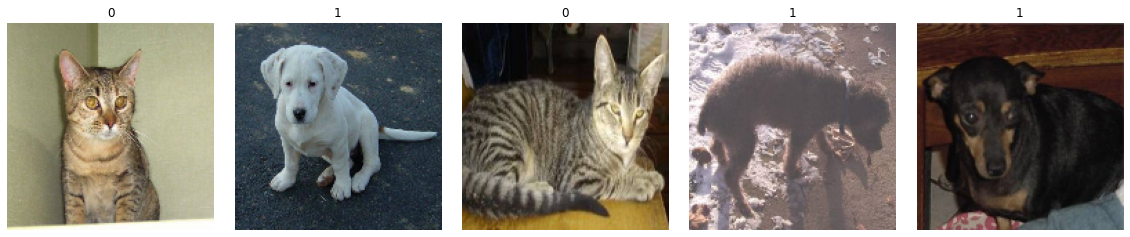

In [23]:
plot_images(X_train_small_150, y_train_small, 5, random_sample=True)

### d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?

Data augmentation makes the model generalise better to the test data. For each training batch the ImageDataGenerator creates a random set of augmented training data, where each picture is changed (for example zoomed or rotated). 

I based my decision


Horizontal flip - for real life pictures 
Rotation - not too much, tried different rotations below
Other hyperparameters according to book

In [6]:
scaled_X_train_small_150 = X_train_small_150.astype("float32") / 255
scaled_X_val_small_150 = X_val_small_150.astype("float32") / 255
scaled_X_test_small_150 = X_test_small_150.astype("float32") / 255
print(f"scaled_X_train_small: Min: {scaled_X_train_small_150.min()}, Max: {scaled_X_train_small_150.max()}")

scaled_X_train_small: Min: 0.0, Max: 1.0


In [7]:
def create_generator(X_train:np.ndarray, y_train:np.ndarray, X_val:np.ndarray, y_val:np.ndarray, rotation:int) -> NumpyArrayIterator:
    """
    Creates ImageDataGenerators for training and validation data. 
    
    Parameters
    ----------
    X_train : np.ndarray
        The training data images
    y_train : np.ndarray
        The training data labels
    X_val : np.ndarray
        The validation data images 
    y_val : np.ndarray
        The validation data labels
    rotation : int
        The rotation angle
        
    Returns
    -------
    train_generator, val_generator : tuple[NumpyArrayIterator, NumpyArrayIterator]
        The training data generator and the validation data generator
    """
    
    train_image_generator = ImageDataGenerator(
                            rotation_range=rotation,
                            shear_range=.2,
                            zoom_range=.2,
                            horizontal_flip=True, 
                            height_shift_range=.2, 
                            width_shift_range=.2)

    val_image_generator = ImageDataGenerator()

    train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
    val_generator = val_image_generator.flow(X_val, y_val, batch_size=32)
    
    return train_generator, val_generator

In [26]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

## 2. Träna modeller (*)
### För uppgifterna nedan, jobba med dataseten en åt gången:

small:
- utan augmentering
- med augmentering

tiny (BONUS):
- utan augmentering
- med augmentering

In [13]:
def CNN_model(input_shape:tuple, kernels:list, optimizer:str, learning_rate:float, dropout_rate:float) -> Sequential:
    """
    Creates a CNN model. 
    
    Parameters
    ----------
    input_shape : tuple[int, int, int]
        The shape of one image
    kernels : list
        The sizes of the kernels from first to last layer
    optimizer : str
        Name of the optimizer to use when compiling
    learning_rate : float
        The learning rate for the specified optimizer
    dropout_rate : float
        The dropout rate
        
    Returns
    -------
    model : Sequential
        The CNN model
    """
    
    model = Sequential(name="CNN_model")

    # The convolutional layers
    for kernel in kernels:
        conv_layer = Conv2D(kernel, 
                            kernel_size=(3, 3), 
                            activation="relu", 
                            kernel_initializer="he_normal", 
                            input_shape=input_shape)
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer=optimizer(learning_rate=learning_rate), metrics=["acc"])

    return model

model = CNN_model(input_shape=(150, 150, 3), kernels=[32, 64, 128, 128], optimizer=Adam, learning_rate=.001, dropout_rate=.3)
model.summary()   

2022-05-10 16:35:07.719283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       14

2022-05-10 16:35:07.819955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:35:07.820818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:35:07.822358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 16:35:07.822679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [12]:
def create_CNN_model(train_data:list, val_data:list, input_shape, fit_generator=False, 
                     kernels=[32, 64, 128, 128], optimizer=Adam, learning_rate:float=.001, 
                     dropout_rate:float=.3, early_stop_patience:int=25) -> Sequential:
    """
    Creates a CNN model. 
    
    Parameters
    ----------
    train_data : list[np.ndarray, np.ndarray]
        The X and y training data as [X, y] OR a generator object
    val_data : list[np.ndarray, np.ndarray] 
        The X and y validation as [X, y] data OR a generator object
    input_shape : tuple[int, int, int]
        The shape of one image
    fit_generator : bool
        True: If a generator is used for training and validation
        False (default): If X and y training and validation data is given
    kernels : list
        The sizes of the kernels from first to last layer (default [32, 64, 128, 128])
    optimizer : str
        Name of the optimizer to use when compiling (default Adam)
    learning_rate : float
        The learning rate for the specified optimizer (default .001)
    dropout_rate : float
        The dropout rate (default .3)
    early_stop_patience : int
        The number of epochs without improvement before training will stop
        
    Returns
    -------
    model : Sequential
        The fitted CNN model
    """

    early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = early_stop_patience, restore_best_weights = True)
    
    model = CNN_model(input_shape=input_shape, kernels=kernels, optimizer=optimizer, learning_rate=learning_rate, dropout_rate=dropout_rate)
    
    if fit_generator == False:        
        model.fit(train_data[0], train_data[1], 
                  epochs = 200, 
                  callbacks = [early_stopper], 
                  validation_data=(val_data[0], val_data[1]))          
    else:    
        model.fit(train_data[0], 
                 steps_per_epoch = 50, 
                 epochs = 200,
                 callbacks = [early_stopper], 
                 validation_data = val_data[0], 
                 validation_steps = 12)
    
    return model

In [8]:
def plot_metrics(model, title):
    """
    Plots loss and accuracy history for a trained model. 
    
    Parameters
    ----------
    model : Sequential
        The trained model
    title : str
        The title of the plot with info about hyperparameters

    Returns
    -------
    None
    """
    
    metrics = pd.DataFrame(model.history.history)
    
    fig, ax = plt.subplots(1, 2, figsize = (12,4))
    
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    ax[0].legend(["Training Loss", "Validation Loss"])
    
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)
    ax[1].legend(["Training Accuracy", "Validation Accuracy"])
    
    fig.suptitle(title)

## Without Augmentation

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

#### Hyperparameter tuning

I will test two different optimizers, Adam and RMSprop. Keras recommend to use the default learning rate for Adam, i.e. .001, and to tune the learning rate for RMSprop. I will therefore try some different learning rates for RMSprop.

I will also try out some different patience values for early stopping. I will use early stopping throughout this lab, in order to avoid overfitting. 

In [14]:
model = create_CNN_model([scaled_X_train_small_150, y_train_small], [scaled_X_val_small_150, y_val_small], input_shape=(150, 150, 3), optimizer=RMSprop, learning_rate=.005, early_stop_patience=25)

2022-05-09 19:35:58.368741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-05-09 19:35:59.884912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 9s 34ms/step - loss: 22.0545 - acc: 0.5238 - val_loss: 0.7022 - val_acc: 0.4625
Epoch 2/200
50/50 [==============================] - 1s 17ms/step - loss: 1.0342 - acc: 0.5100 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 3/200
50/50 [==============================] - 1s 17ms/step - loss: 0.8408 - acc: 0.5213 - val_loss: 0.6915 - val_acc: 0.5100
Epoch 4/200
50/50 [==============================] - 1s 17ms/step - loss: 0.8896 - acc: 0.5213 - val_loss: 0.6944 - val_acc: 0.5000
Epoch 5/200
50/50 [==============================] - 1s 17ms/step - loss: 0.7168 - acc: 0.5200 - val_loss: 0.6873 - val_acc: 0.5300
Epoch 6/200
50/50 [==============================] - 1s 17ms/step - loss: 0.7198 - acc: 0.5269 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 7/200
50/50 [==============================] - 1s 17ms/step - loss: 0.9237 - acc: 0.5531 - val_loss: 0.7648 - val_acc: 0.5175
Epoch 8/200
50/50 [==============================] - 1s 17ms/step - loss: 0.7006 - acc:

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: RMSprop, Learning Rate: .005, Patience: 25")

#### Summary of Results Without Augmentation

|Optimizer|Learning Rate|Patience|Number of Epochs|Best Validation Accuracy|
|---------|-------------|--------|----------------|------------------------|
| Adam    | .001        | 15     | 13/28          | .688                   |
| Adam    | .001        | 25     | 14/39          | .690                   |
| RMSprop | .0005       | 15     | 23/38          | .705                   |
| RMSprop | .001        | 15     | 10/25          | .690                   |
| RMSprop | .005        | 15     | 14/29          | .720                   |
| RMSprop | .0005       | 25     | 53/78          | .755                   |
| RMSprop | .001        | 25     | 22/47          | .728                   |
| RMSprop | .005        | 25     | 27/52          | .715                   |

### b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför.

Glöm inte att evaluera på valideringsdatan.

In [ ]:
model = create_CNN_model([scaled_X_train_small, y_train_small], 
                         [scaled_X_val_small, y_val_small], 
                         input_shape=(150, 150, 3), 
                         kernels=[32, 64, 128, 256], 
                         optimizer=RMSprop, learning_rate=.0005, 
                         early_stop_patience=25, 
                         drop_rate=.6)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(metrics, "Optimizer: RMSprop(.0005), Patience: 25, Layers:[32, 64, 128, 256], Drop Rate: .6")

I continue with changing the last kernel to 256, so that the kernels are [32, 64, 128, 256]. I test this in combination with different dropout rates.

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 14/39   | .690***   |
|32, 64, 128, 128| Adam   | .001   | 25     | .4 | 20/45   | .707      |
|32, 64, 128, 128| Adam   | .001   | 25     | .5 | 44/69   | .740      |
|32, 64, 128, 128| Adam   | .001   | 25     | .6 | 39/64   | .745      |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | 35/60   | .770      |
|32, 64, 128, 128| Adam   | .001   | 25     | .8 | 50/75   | .750      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | 53/78   | .755*     |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .4 | 35/60   | .730      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .5 | 17/42   | .712      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 22/47   | .728**    |
|32, 64, 128, 256| Adam   | .001   | 25     | .3 | 12/37   | .720      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 20/45   | .725      |
|32, 64, 128, 256| Adam   | .001   | 25     | .5 | 51/76   | .740      |
|32, 64, 128, 256| Adam   | .001   | 25     | .6 | 20/45   | .733      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .3 | 32/57   | .712      | 
|32, 64, 128, 256| RMSprop| .0005  | 25     | .4 | 51/76   | .745      | 
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | 70/95   | .767      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .6 | 39/64   | .740      |

\* Best score from last run <br>
** Second best score from last run <br>
*** Best score with optimizer=Adam

The best score from this run was .770.

#### Change Image Size

In [15]:
X_train_small_100 = resize_images(X_train_small, (100, 100))
X_val_small_100 = resize_images(X_val_small, (100, 100))
X_train_small_200 = resize_images(X_train_small, (200, 200))
X_val_small_200 = resize_images(X_val_small, (200, 200))

scaled_X_train_small_200 = X_train_small_200.astype("float32") / 255
scaled_X_val_small_200 = X_val_small_200.astype("float32") / 255
scaled_X_train_small_100 = X_train_small_100.astype("float32") / 255
scaled_X_val_small_100 = X_val_small_100.astype("float32") / 255

In [ ]:
model = create_CNN_model([scaled_X_train_small_200, y_train_small], 
                         [scaled_X_val_small_200, y_val_small], 
                         input_shape=(200, 200, 3), 
                         kernels=[32, 64, 128, 256], 
                         optimizer=RMSprop, learning_rate=.0005, 
                         early_stop_patience=25, 
                         dropout_rate=0.97)

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Optimizer: RMSprop(.0005), Layers: [32, 64, 128, 256], Drop Rate: .97, Image Size: (200, 200)")

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Image Size|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|------------|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (100, 100) | 73/98   | .798      |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (150, 150) | 35/60   | .770*     |
|32, 64, 128, 128| Adam   | .001   | 25     | .7 | (200, 200) | 38/63   | .738      |
|32, 64, 128, 128| Adam   | .001   | 25     | .9 | (200, 200) | 73/98   | .762      |
|32, 64, 128, 128| Adam   | .001   | 25     | .95| (200, 200) | 13/38   | .575      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (100, 100) | 21/46   | .730      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (150, 150) | 53/78   | .755***   |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .3 | (200, 200) | 9/34    | .705      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .7 | (200, 200) | 16/41   | .748      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .9 | (200, 200) | 94/119  | .830      |
|32, 64, 128, 128| RMSprop| .0005  | 25     | .95| (200, 200) | 85/110  | .798      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (100, 100) | 47/72   | .755      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (150, 150) | 70/95   | .767**    |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | (200, 200) | 27/52   | .707      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .6 | (200, 200) | 61/86   | .735      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .7 | (200, 200) | 44/69   | .755      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .8 | (200, 200) | 51/76   | .770      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .9 | (200, 200) | 46/71   | .800      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .95| (200, 200) | 94/119  | .825      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .96| (200, 200) | 131/156 | .832      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .97| (200, 200) | 87/112  | .793      |


\* Best score from last run <br>
** Second best score from last run <br>
*** Third best score from last run <br>


The model performed best with a very high dropout rate (.96). However, based on the plots, the model performed more evenly with a dropout rate of .9 and I will therefore continue with that model. 

### c) Välj en modell, träna på tränings- och valideringsdatan. Gör inferens på testdatan och utvärdera din modell.

In [16]:
# Resize test images to 200
X_test_small_200 = resize_images(X_test_small, (200, 200))
scaled_X_test_small_200 = X_test_small_200.astype("float32") / 255

In [52]:
X_train_full = np.concatenate((scaled_X_train_small_200, scaled_X_val_small_200))
y_train_full = np.concatenate((y_train_small, y_val_small))
X_train_full.shape, y_train_full.shape

((2000, 200, 200, 3), (2000,))

In [70]:
final_model_no_aug = CNN_model(input_shape=(200, 200, 3), kernels=[32, 64, 128, 256], optimizer=RMSprop, learning_rate=.0005, dropout_rate=.9)
final_model_no_aug.fit(X_train_full, y_train_full, epochs=46)

Epoch 1/46
63/63 [==============================] - 2s 28ms/step - loss: 0.9834 - acc: 0.5165
Epoch 2/46
63/63 [==============================] - 2s 28ms/step - loss: 0.7012 - acc: 0.5470
Epoch 3/46
63/63 [==============================] - 2s 28ms/step - loss: 0.6753 - acc: 0.5905
Epoch 4/46
63/63 [==============================] - 2s 28ms/step - loss: 0.6550 - acc: 0.6190
Epoch 5/46
63/63 [==============================] - 2s 28ms/step - loss: 0.6293 - acc: 0.6480
Epoch 6/46
63/63 [==============================] - 2s 29ms/step - loss: 0.6169 - acc: 0.6765
Epoch 7/46
63/63 [==============================] - 2s 28ms/step - loss: 0.5993 - acc: 0.6645
Epoch 8/46
63/63 [==============================] - 2s 27ms/step - loss: 0.5992 - acc: 0.6840
Epoch 9/46
63/63 [==============================] - 2s 28ms/step - loss: 0.5712 - acc: 0.7125
Epoch 10/46
63/63 [==============================] - 2s 27ms/step - loss: 0.5774 - acc: 0.7015
Epoch 11/46
63/63 [==============================] - 2s 27m

In [84]:
y_pred_small_no_aug = final_model_no_aug.predict(scaled_X_test_small_200)
y_pred_small_no_aug = (y_pred_small_no_aug > .5)*1

In [72]:
def print_and_plot_results(y_true:np.ndarray, y_pred:np.ndarray, data_name:str) -> None:
    """
    Prints a classification report and plots a confusion matrix. 
    
    Parameters
    ----------
    y_true : pd.Series
        The real y-values.
    y_pred : np.ndarray
        The predicted y-values.
    model_name : str
        The name of the model.
    """

    classification_report_ = classification_report(y_true, y_pred)
    print(f"Classification Report for {data_name}: \n {classification_report_}")
    
    cm = confusion_matrix(y_true, y_pred)
    cm_fig = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"]).plot()
    _ = cm_fig.ax_.set(title=f"{data_name}: Results on Test Data")


Classification Report for Data Without Augmentation: 
               precision    recall  f1-score   support

           0       0.83      0.67      0.74       250
           1       0.72      0.86      0.79       250

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.76       500
weighted avg       0.78      0.77      0.76       500



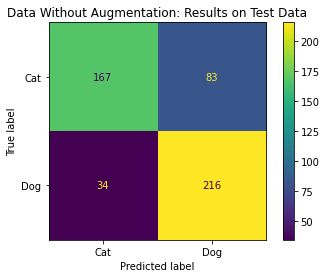

In [85]:
print_and_plot_results(y_test_small, y_pred_small_no_aug, "Data Without Augmentation")

In [86]:
final_model_no_aug.save("DogsVsCatsPredictorNoAug.h5")

### d) Tag ett eller flera av nätverken (VGG16, Resnet, Xception, Inception), läs deras forskningsartikel, sammanfatta kort ca 1/2 - 1 sida för en artikel. Utför därefter transfer learning och evaluera din modell. Beskriv också hur transfer learning fungerar.

The code is loosely based on ...

In [49]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [50]:
train_features = base_model.predict(scaled_X_train_small_200, batch_size=32)
val_features = base_model.predict(scaled_X_val_small_200, batch_size=32)

In [31]:
#train_features = train_features.reshape((train_features.shape[0], 6 * 6 * 512))
#val_features = val_features.reshape((val_features.shape[0], 6 * 6 * 512))
#train_features.shape

In [56]:
model = Sequential()
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer="he_normal"))#, input_dim=6 * 6 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(learning_rate=0.00002),
              loss='binary_crossentropy',
              metrics=['acc'])

early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 15, restore_best_weights = True)

model.fit(train_features, y_train_small,
          epochs=100,
          callbacks=[early_stopper],
          batch_size=20,
          validation_data=(val_features, y_val_small))

Epoch 1/100
80/80 [==============================] - 1s 7ms/step - loss: 0.5346 - acc: 0.7319 - val_loss: 0.3840 - val_acc: 0.8225
Epoch 2/100
80/80 [==============================] - 0s 5ms/step - loss: 0.3362 - acc: 0.8581 - val_loss: 0.3096 - val_acc: 0.8650
Epoch 3/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2687 - acc: 0.8819 - val_loss: 0.2806 - val_acc: 0.8850
Epoch 4/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2211 - acc: 0.9106 - val_loss: 0.2788 - val_acc: 0.8750
Epoch 5/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2001 - acc: 0.9256 - val_loss: 0.2533 - val_acc: 0.8975
Epoch 6/100
80/80 [==============================] - 0s 5ms/step - loss: 0.1646 - acc: 0.9400 - val_loss: 0.2783 - val_acc: 0.8750
Epoch 7/100
80/80 [==============================] - 0s 5ms/step - loss: 0.1547 - acc: 0.9375 - val_loss: 0.2352 - val_acc: 0.9000
Epoch 8/100
80/80 [==============================] - 0s 5ms/step - loss: 0.1341 - a

In [57]:
max(model.history.history["val_acc"])

0.925000011920929

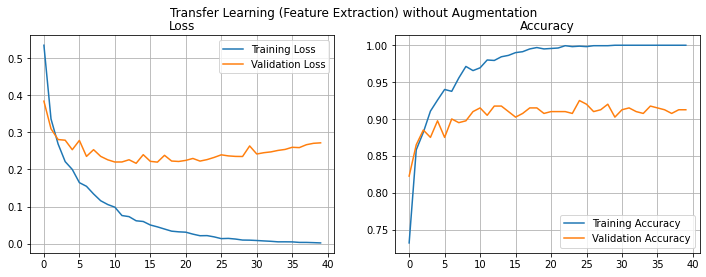

In [58]:
plot_metrics(model, "Transfer Learning (Feature Extraction) without Augmentation")

## With Augmentation

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [ ]:
model = create_model([train_generator_small], 
                     [val_generator_small], 
                     input_shape=(150, 150, 3),
                     fit_generator=True,
                     optimizer=Adam, 
                     learning_rate=.001, 
                     early_stop_patience=25)

In [ ]:
max(model.history.history["val_acc"])

In [ ]:
plot_metrics(model, "Optimizer: Adam, Learning Rate: .001, Patience: 25")

#### Summary of Results With Augmentation 

|Optimizer|Learning Rate|Patience|Number of Epochs|Best Validation Accuracy|
|---------|-------------|--------|----------------|------------------------|
| Adam    | .001        | 15     | 76/91          | .792                   |
| Adam    | .001        | 25     | 110/135        | .857                   |
| RMSprop | .0005       | 15     | 125/140        | .828                   |
| RMSprop | .0005       | 25     | 122/147        | .828                   |
| RMSprop | .001        | 15     | 86/101         | .826                   |
| RMSprop | .001        | 25     | 122/147        | .849                   |
| RMSprop | .005        | 15     | 46/61          | .727                   |
| RMSprop | .005        | 25     | 58/83          | .737                   |

I will continue investigating Adam (learning rate=.001, patience 25) and RMSprop (learning rate=.001, patience=25).

### b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför.

Glöm inte att evaluera på valideringsdatan.

In [ ]:
model = create_model([train_generator_small], 
                     [val_generator_small], 
                     input_shape=(150, 150, 3),
                     fit_generator=True,
                     kernels=[32, 64, 128, 256],
                     optimizer=Adam, 
                     learning_rate=.001, 
                     early_stop_patience=25, 
                     drop_rate=.4)

In [ ]:
max(model.history.history["val_acc"])

In [ ]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics, "Optimizer: Adam(.001), Patience: 25, Layers: [32, 64, 128, 256], Drop Rate: .4")

I continue with changing the last kernel to 256, so that the kernels are [32, 64, 128, 256]. I test this in combination with different dropout rates.

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 110/135 | .857*     |
|32, 64, 128, 128| Adam   | .001   | 25     | .4 | 72/97   | .813      |
|32, 64, 128, 128| Adam   | .001   | 25     | .5 | 112/137 | .844      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 122/147 | .849**    |
|32, 64, 128, 128| RMSprop| .001   | 25     | .4 | 84/109  | .807      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .5 | 47/72   | .818      |
|32, 64, 128, 256| Adam   | .001   | 25     | .3 | 88/113  | .839      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 132/157 | .865      |
|32, 64, 128, 256| Adam   | .001   | 25     | .5 | 88/113  | .805      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .3 | 163/188 | .841      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .4 | 97/122  | .820      |
|32, 64, 128, 256| RMSprop| .0005  | 25     | .5 | 98/123  | .828      |

\* Best score from last run <br>
** Second best score from last run

The best performing model got .865. 

#### Change Rotation Range

In [ ]:
train_generator_small_40, val_generator_small_40 = create_generator(scaled_X_train_small,
                                                                  y_train_small,
                                                                  scaled_X_val_small,
                                                                  y_val_small,
                                                                  rotation=40)

In [ ]:
model = create_model([train_generator_small_40], 
                     [val_generator_small_40], 
                     input_shape=(150, 150, 3),
                     fit_generator=True,
                     kernels=[32, 64, 128, 128],
                     optimizer=RMSprop, 
                     learning_rate=.001, 
                     early_stop_patience=25, 
                     drop_rate=.3)

In [ ]:
max(model.history.history["val_acc"])

In [ ]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics, "Optimizer: RMSprop(.001), Layers:[32, 64, 128, 128], Drop Rate: .3, Rotation: 40")

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Rotation|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 20      | 101/126 | .839      |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 30      | 110/135 | .857**    |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 40      | 145/170 | .852      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 20      | 42/67   | .784      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 30      | 122/147 | .849***   |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 40      | 187/200 | .846      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 20      | 42/67   | .792      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 30      | 132/157 | .865*     |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 40      | 72/97   | .844      |


\* Best from last run <br>
** Second best from earlier run <br>
*** Third best from earlier run <br>

Changing rotation to either 20 or 40 did not make the models perform better. 

#### Change Image Size

In [53]:
X_train_small_100 = resize_images(X_train_small, (100, 100))
X_val_small_100 = resize_images(X_val_small, (100, 100))
X_train_small_200 = resize_images(X_train_small, (200, 200))
X_val_small_200 = resize_images(X_val_small, (200, 200))

scaled_X_train_small_200 = X_train_small_200.astype("float32") / 255
scaled_X_val_small_200 = X_val_small_200.astype("float32") / 255
scaled_X_train_small_100 = X_train_small_100.astype("float32") / 255
scaled_X_val_small_100 = X_val_small_100.astype("float32") / 255

In [56]:
train_generator_small_100, val_generator_small_100 = create_generator(scaled_X_train_small_100,
                                                                      y_train_small,
                                                                      scaled_X_val_small_100,
                                                                      y_val_small,
                                                                      rotation=30)

train_generator_small_200, val_generator_small_200 = create_generator(scaled_X_train_small_200,
                                                                      y_train_small,
                                                                      scaled_X_val_small_200,
                                                                      y_val_small,
                                                                      rotation=30)

In [57]:
model = create_CNN_model([train_generator_small_200], 
                     [val_generator_small_200], 
                     input_shape=(200, 200, 3),
                     fit_generator=True,
                     kernels=[32, 64, 128, 256],
                     optimizer=Adam, 
                     learning_rate=.001, 
                     early_stop_patience=25, 
                     dropout_rate=.7)

TypeError: create_CNN_model() got an unexpected keyword argument 'drop_rate'

In [ ]:
max(model.history.history["val_acc"])

In [ ]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics, "Optimizer: Adam(.001), Layers:[32, 64, 128, 256], Drop Rate: .7, Image Size: (200, 200)")

|Kernel Sizes|Optimizer|Learning Rate|Patience|Dropout Rate|Image Size|Number of Epochs|Best Validation Accuracy|
|----------------|--------|--------|--------|----|---------|---------|-----------|
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 100, 100| 41/66   | .797      |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 150, 150| 110/135 | .857**    |
|32, 64, 128, 128| Adam   | .001   | 25     | .3 | 200, 200| 122/147 | .849      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 100, 100| 103/128 | .831      |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 150, 150| 122/147 | .849***   |
|32, 64, 128, 128| RMSprop| .001   | 25     | .3 | 200, 200| 128/153 | .859      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 100, 100| 107/132 | .823      |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 150, 150| 132/157 | .865*     |
|32, 64, 128, 256| Adam   | .001   | 25     | .4 | 200, 200| 112/137 | .862      |
|32, 64, 128, 256| Adam   | .001   | 25     | .7 | 200, 200| 129/154 | .844      |

\* Best from last run <br>
** Second best from earlier run <br>
*** Third best from earlier run <br>

### c) Välj en modell, träna på tränings- och valideringsdatan. Gör inferens på testdatan och utvärdera din modell.

In [11]:
X_train_full_150 = np.concatenate((scaled_X_train_small_150, scaled_X_val_small_150))
y_train_full = np.concatenate((y_train_small, y_val_small))
X_train_full_150.shape, y_train_full.shape

((2000, 150, 150, 3), (2000,))

In [59]:
train_generator_full, _ = create_generator(X_train_full_150,
                                            y_train_full,
                                            X_test_small_150,
                                            y_test_small,
                                            rotation=30)

In [61]:
final_model_aug = CNN_model(input_shape=(150, 150, 3), kernels=[32, 64, 128, 256], optimizer=Adam, learning_rate=.001, dropout_rate=.4)
final_model_aug.fit(train_generator_full, epochs=132)

Epoch 1/132
63/63 [==============================] - 10s 153ms/step - loss: 1.0595 - acc: 0.5185
Epoch 2/132
63/63 [==============================] - 9s 141ms/step - loss: 0.6908 - acc: 0.5325
Epoch 3/132
63/63 [==============================] - 9s 143ms/step - loss: 0.6889 - acc: 0.5410
Epoch 4/132
63/63 [==============================] - 10s 153ms/step - loss: 0.6884 - acc: 0.5625
Epoch 5/132
63/63 [==============================] - 9s 143ms/step - loss: 0.6814 - acc: 0.5720
Epoch 6/132
63/63 [==============================] - 10s 151ms/step - loss: 0.6730 - acc: 0.5925
Epoch 7/132
63/63 [==============================] - 9s 144ms/step - loss: 0.6608 - acc: 0.5965
Epoch 8/132
63/63 [==============================] - 9s 149ms/step - loss: 0.6446 - acc: 0.6140
Epoch 9/132
63/63 [==============================] - 9s 143ms/step - loss: 0.6338 - acc: 0.6290
Epoch 10/132
63/63 [==============================] - 9s 144ms/step - loss: 0.6207 - acc: 0.6445
Epoch 11/132
63/63 [================

Classification Report for Data With Augmentation: 
               precision    recall  f1-score   support

           0       0.94      0.79      0.86       250
           1       0.82      0.95      0.88       250

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



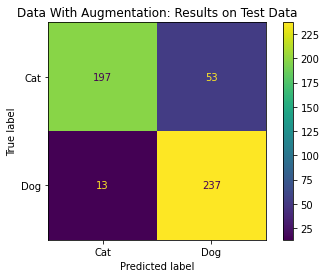

In [78]:
y_pred_small_aug = final_model_aug.predict(scaled_X_test_small_150)
y_pred_small_aug = (y_pred_small_aug > .5)*1

print_and_plot_results(y_test_small, y_pred_small_aug, "Data With Augmentation")

In [80]:
final_model_aug.save("DogsVsCatsPredictor.h5")

### d) Tag ett eller flera av nätverken (VGG16, Resnet, Xception, Inception), läs deras forskningsartikel, sammanfatta kort ca 1/2 - 1 sida för en artikel. Utför därefter transfer learning och evaluera din modell. Beskriv också hur transfer learning fungerar.

In [21]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

In [22]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(640, activation="relu", kernel_initializer="he_normal"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

for layer in base_model.layers:
    layer.trainable = False #Freeze all layers, feature extraction

model.compile(optimizer=RMSprop(.00002), loss="binary_crossentropy", metrics=["acc"])   

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 640)               5243520   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 641       
Total params: 19,958,849
Trainable params: 5,244,161
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 25, restore_best_weights = True)

model.fit(train_generator_small,
          epochs=200,
          callbacks=[early_stopper],
          batch_size=20,
          validation_data=val_generator_small)


Epoch 1/200
21/50 [===========>..................] - ETA: 5s - loss: 0.6582 - acc: 0.6250

KeyboardInterrupt: 

0.9479166865348816


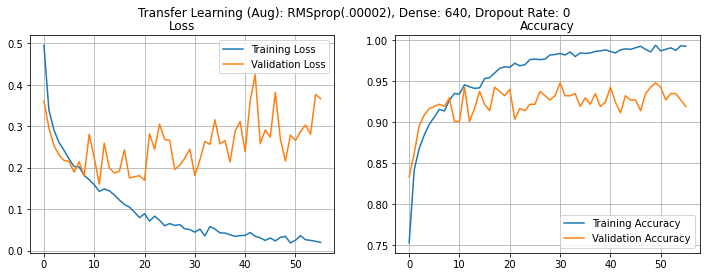

In [82]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Transfer Learning (Aug): RMSprop(.00002), Dense: 640, Dropout Rate: 0")

|Optimizer|Learning Rate|Nodes in Dense|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|--------|----------|---------|--------|----|---------|---------|
| Adam   | .0001    | 256     | 25     | 0  | 32/57   | .933    |
| Adam   | .0001    | 512     | 25     | 0  | 27/52   | .933    |
| Adam   | .001     | 256     | 25     | 0  | 37/62   | .925    |
| Adam   | .001     | 512     | 25     | 0  | 16/41   | .928    |
| Adam   | .001     | 512     | 25     | .3 | 12/37   | .920    |
| Adam   | .001     | 512     | 25     | .4 | 20/45   | .928    |
| RMSprop| .00001   | 512     | 35     | 0  | 100/135 | .930    |
| RMSprop| .00002   | 256     | 25     | 0  | 52/77   | .930    |
| RMSprop| .00002   | 512     | 25     | .3 | 81/106  | .933    |
| RMSprop| .00002   | 512     | 25     | 0  | 68/93   | .935    |
| RMSprop| .00002   | 640     | 25     | 0  | 48/73   | .930    |


In [36]:
train_generator_small, val_generator_small = create_generator(scaled_X_train_small_150,
                                                              y_train_small,
                                                              scaled_X_val_small_150,
                                                              y_val_small,
                                                              rotation=30)

In [37]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
model.compile(optimizer=RMSprop(.00002), loss="binary_crossentropy", metrics=["acc"])   

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


In [38]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 25, restore_best_weights = True)

model.fit(train_generator_small,
          epochs=200,
          callbacks=[early_stopper],
          batch_size=32,
          validation_data=val_generator_small)

Epoch 1/200
50/50 [==============================] - 10s 188ms/step - loss: 0.5818 - acc: 0.6812 - val_loss: 0.3991 - val_acc: 0.8125
Epoch 2/200
50/50 [==============================] - 10s 193ms/step - loss: 0.4251 - acc: 0.7975 - val_loss: 0.2733 - val_acc: 0.8950
Epoch 3/200
50/50 [==============================] - 10s 200ms/step - loss: 0.3416 - acc: 0.8456 - val_loss: 0.2571 - val_acc: 0.9125
Epoch 4/200
50/50 [==============================] - 9s 184ms/step - loss: 0.3057 - acc: 0.8637 - val_loss: 0.2245 - val_acc: 0.9225
Epoch 5/200
50/50 [==============================] - 9s 179ms/step - loss: 0.2716 - acc: 0.8838 - val_loss: 0.2313 - val_acc: 0.9025
Epoch 6/200
50/50 [==============================] - 9s 180ms/step - loss: 0.2598 - acc: 0.8863 - val_loss: 0.2538 - val_acc: 0.9025
Epoch 7/200
50/50 [==============================] - 10s 207ms/step - loss: 0.2303 - acc: 0.9038 - val_loss: 0.2552 - val_acc: 0.9075
Epoch 8/200
50/50 [==============================] - 9s 186ms/ste

In [ ]:
print(max(model.history.history["val_acc"]))
plot_metrics(model, "Transfer Learning (Aug) Fine Tuning: RMSprop(.00002), Dense: 512, Dropout Rate: .2")

0.9474999904632568


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc4a1d803b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc4a1d803b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


|Optimizer|Learning Rate|Nodes in Dense|Patience|Dropout Rate|Number of Epochs|Best Validation Accuracy|
|--------|----------|---------|--------|----|---------|-------|
| RMSprop| .00002   | 512     | 25     | 0  | 23/48   | .945  |
| RMSprop| .00002   | 512     | 25     | .2 | 40/65   | .955  |
| RMSprop| .00002   | 512     | 25     | .3 | 43/68   | .953  |
| RMSprop| .00002   | 512     | 25     | .4 | 23/48   | .955  |
| RMSprop| .00002   | 512     | 25     | .5 | 15/40   | .942  |





In [ ]:
model.fit(train_generator_full, epochs=43)

In [ ]:
y_pred = model.predict(scaled_X_test_small_150)
y_pred = (y_pred > .5)*1

print_and_plot_results(y_test_small, y_pred, "Data With Augmentation")

> 